In [1]:
import imageio
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import IPython.display
%matplotlib inline

# Graph

In [4]:
import os, shutil
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from graphviz import Digraph


In [5]:
def _state_name(state):
    # Removing : since file system doesn't like it.
    # graphviz might not either? since it warns about "port"
    return dump_state(state).replace(':', '_')


In [87]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import agent
import blockworld

In [88]:
initial = ((), ('D', 'A'), ('C', 'B'))
p = blockworld.Blockworld(initial, blockworld.Blockworld.generate_tower_of_london_goals(initial, column_index=1, debug=False))

things = set()
for _ in range(10):
    history, _ = agent.solve_using_ordered_goal_subset_astar(p, k=1)
    states = tuple(s for a, s in history)
    things.add(states)
print(len(things))

2


total states 11 total unique edges 11


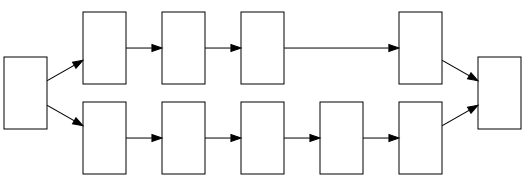

In [98]:

def _state_sequence_to_images_4block(state, fn):
    #blue = tuple(int(c, 16) for c in ['22', '99', 'ee'])
    #yellow = tuple(int(c, 16) for c in ['ff', 'dd', '47'])
    gray = tuple(int(c, 16)/255 for c in ['aa', 'aa', 'aa'])
    green = tuple(int(c, 16)/255 for c in ['34', 'd0', '58'])

    pos_to_color = {
        # colidx=1
        (1, ridx, letter): green
        for ridx, letter in enumerate(sorted([l for col in state for l in col], reverse=True))
    }

    bsize = 100
    num_blocks = 5
    num_spaces = 3
    f, ax = plt.subplots(figsize=(num_spaces, num_blocks))
    ax.set_xlim([0, num_spaces * bsize])
    ax.set_ylim([0, num_blocks * bsize])

    for colidx, col in enumerate(state):
        for rowidx, label in enumerate(col):
            c = pos_to_color.get((colidx, rowidx, label), gray)
            left = colidx * bsize
            bottom = rowidx * bsize
            p = matplotlib.patches.Rectangle(
                (left, bottom), bsize, bsize,
                edgecolor='black', facecolor=c)
            ax.add_artist(p)
            ax.text(
                left + bsize/2,
                # HACK not sure why we need this -5
                bottom + bsize/2 - 5,
                label,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=40, color='white',
                transform=ax.transData)

    # HACK from https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image-in-matplotlib
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.axis('off')
    plt.savefig(fn, bbox_inches='tight', pad_inches=0)
    plt.close(f)




def _state_name(state):
    # Removing : since file system doesn't like it.
    # graphviz might not either? since it warns about "port"
    return dump_state(state).replace(':', '_')

def _make_problem_graph2(df, initial):
    end_state = ((), tuple(sorted([l for col in initial for l in col], reverse=True)), ())

    if not os.path.exists('graph-tmp'):
        os.mkdir('graph-tmp')

    problem_df = df[df.states.apply(lambda s: s[0] == initial)]
    total_subjects = problem_df.shape[0]

    state_counter = Counter()
    states = set()
    for _, row in problem_df.iterrows():
        # Make unique list of state pairs for each subject.
        # - want them unique within a subject so we don't double count a subject if they made the same move twice.
        state_pairs = {
            (row.states[idx - 1], row.states[idx])
            for idx in range(1, len(row.states))
        }
        # Add these pairs to the counter.
        state_counter.update(state_pairs)
        # Add states to full list of states
        states |= set(row.states)

    print('total states', len(states), 'total unique edges', len(state_counter))

    # Make graph with each node, and add edge annotated appropriately for each state pair.
    d = Digraph(engine='dot')
    d.graph_attr['rankdir'] = 'LR'
    d.graph_attr['margin'] = '0'

    sg1 = Digraph(name='cluster_0', engine='dot')
    #sg1.attr(style='filled')
    sg1.attr(color='white')
    sg2 = Digraph()
    sg3 = Digraph()

    for state in states:
        # Generate and save images for each of the states visited for a problem.
        fn = f'graph-tmp/{_state_name(state)}.svg'
        _state_sequence_to_images_4block(state, fn)

        '''
        if state in [
            ((), ('D', 'A'), ('C', 'B')),
            (('B',), ('D', 'A'), ('C',)),
            (('B', 'A'), ('D',), ('C',)),
            (('A',), ('D',), ('C', 'B')),
            (('A', 'B'), ('D',), ('C',)),
        ]:
            graph = sg1
        elif state in [
            (('B', 'A'), ('D', 'C'), ()),
            (('B',), ('D', 'C'), ('A',)),
            (('A', 'B'), ('D', 'C'), ()),
        ]:
            graph = sg2
        elif state in [
            ((), ('D', 'C', 'B'), ('A',)),
            (('A',), ('D', 'C', 'B'), ()),
            ((), ('D', 'C', 'B', 'A'), ()),
        ]:
            graph = sg3
        '''
        if state in [
            (('B', 'A'), ('D', 'C'), ()),
            (('A', 'B'), ('D', 'C'), ()),
        ]:
            graph = sg1
        else:
            graph = d

        graph.node(
            _state_name(state),
            '',
            #'* * *' if state == initial else
            #'END' if state == end_state else '',
            image=fn,
            fixedsize='true',
            width='0.6pt',
            height='1pt',
            shape='box',
        )

    for (st1, st2), count in state_counter.items():
        # - will either do opacity or we'll label the edge with a number
        #d.edge(_state_name(st1), _state_name(st2), label=str(count), fontsize="10pt")
        graph.edge(_state_name(st1), _state_name(st2))

    # Delete the directory with images. ?? or not
    #shutil.rmtree('graph-tmp')

    d.subgraph(sg1)
    d.subgraph(sg2)
    d.subgraph(sg3)

    return d

import pandas as pd
fake_df = pd.DataFrame([
    dict(states=states)
    for states in things
])
g = _make_problem_graph2(fake_df, initial)
for fmt in ['eps', 'png', 'pdf']:
    g.render(f'example-4-block', format=fmt)
g

In [51]:
for t in things:
    print()
    for s in t:
        print(str(s)+',')


((), ('D', 'A'), ('C', 'B')),
(('B',), ('D', 'A'), ('C',)),
(('B', 'A'), ('D',), ('C',)),
(('B', 'A'), ('D', 'C'), ()),
(('B',), ('D', 'C'), ('A',)),
((), ('D', 'C', 'B'), ('A',)),
((), ('D', 'C', 'B', 'A'), ()),

((), ('D', 'A'), ('C', 'B')),
(('A',), ('D',), ('C', 'B')),
(('A', 'B'), ('D',), ('C',)),
(('A', 'B'), ('D', 'C'), ()),
(('A',), ('D', 'C', 'B'), ()),
((), ('D', 'C', 'B', 'A'), ()),


In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
plt.ioff()

# Create a new figure, plot into it, then close it so it never gets displayed
fig = plt.figure()
plt.plot([1,2,3])
plt.savefig('/tmp/test0.png')
plt.close(fig)


def _state_sequence_to_images3(state, fn):
    bsize = 100
    num_blocks = 5
    num_spaces = 3
    #blue = tuple(int(c, 16) for c in ['22', '99', 'ee'])
    #yellow = tuple(int(c, 16) for c in ['ff', 'dd', '47'])
    gray = tuple(int(c, 16)/255 for c in ['aa', 'aa', 'aa'])
    green = tuple(int(c, 16)/255 for c in ['34', 'd0', '58'])

    pos_to_color = {
        # colidx=1
        (1, ridx, letter): green
        for ridx, letter in enumerate(sorted([l for col in state for l in col], reverse=True))
    }

    bsize = 100
    num_blocks = 3
    num_spaces = 3
    f, ax = plt.subplots(figsize=(num_spaces, num_blocks))
    ax.set_xlim([0, num_spaces * bsize])
    ax.set_ylim([0, num_blocks * bsize])

    for colidx, col in enumerate(state):
        for rowidx, label in enumerate(col):
            c = gray
            if (
                (label == 'C' and len(col) > rowidx + 1 and col[rowidx+1] == 'B') or
                (label == 'B' and len(col) > rowidx + 1 and col[rowidx+1] == 'A') or
                (label == 'B' and rowidx != 0 and col[rowidx-1] == 'C') or
                (label == 'A' and rowidx != 0 and col[rowidx-1] == 'B')
            ):
                c = green
            left = colidx * bsize
            bottom = rowidx * bsize
            p = matplotlib.patches.Rectangle(
                (left, bottom), bsize, bsize,
                edgecolor='black', facecolor=c)
            ax.add_artist(p)
            ax.text(
                left + bsize/2,
                # HACK not sure why we need this -5
                bottom + bsize/2 - 5,
                label,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=40, color='white',
                transform=ax.transData)

    # HACK from https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image-in-matplotlib
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.axis('off')
    plt.savefig(fn, bbox_inches='tight', pad_inches=0)
    plt.close(f)

_state_sequence_to_images3(((), ('A', 'B'), ('C', 'D')), 'hi.eps')

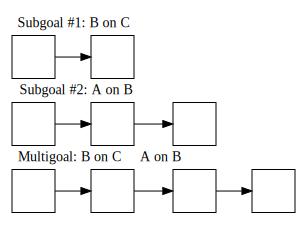

In [85]:
suss = ((), ('A', 'C'), ('B',))
sss = [
    [
        suss,
        ((), ('A', 'C', 'B'), ()),
    ],
    [
        suss,
        (('C',), ('A',), ('B',)),
        (('C',), (), ('B', 'A')),
    ],
    [
        suss,
        (('C',), ('A',), ('B',)),
        (('C', 'B'), ('A',), ()),
        (('C', 'B', 'A'), (), ()),
    ],
]

labels = [
    'Subgoal #1: B on C',
    'Subgoal #2: A on B',
    'Multigoal: B on C \u2227 A on B',
]

g = Digraph(engine='dot')
g.graph_attr['rankdir'] = 'LR'
g.graph_attr['margin'] = '0'
for idx, (states, label) in enumerate(reversed(list(zip(sss, labels)))):
    _sname = lambda s: _state_name(s)+str(idx)

    d = Digraph(name=f'cluster_{idx}')

    #for s in states:
    #    d.node(_sname(s))
    for s1, s2 in zip(states[:-1], states[1:]):
        d.edge(_sname(s1), _sname(s2))

    for s in states:
        # Generate and save images for each of the states visited for a problem.
        fn = f'graph-tmpzz/{_state_name(s)}.svg'
        _state_sequence_to_images3(s, fn)
          
        d.node(
            _sname(s),
            '',
            image=fn,
            fixedsize='true',
            width='0.6pt',
            #height='1pt',
            height='0.6pt',
            shape='box',
        )

    d.attr(
        color='white',
        label=label,
        labeljust='l',
    )
    g.subgraph(d)

for fmt in ['eps', 'png', 'svg', 'pdf']:
    g.render(f'example-suss', format=fmt)

g